In [35]:
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
data = pd.DataFrame(df)

# Separate the wavelengths and flux values
wavelengths = sorted_wavelengths
flux_values = df

# Normalize the flux values
# scaler = MinMaxScaler()
# flux_values_normalized = scaler.fit_transform(flux_values)

# Convert to PyTorch tensors
flux_tensor = torch.tensor(flux_values, dtype=torch.float32)

print("Data loaded and preprocessed.")
flux_tensor.shape

Data loaded and preprocessed.


torch.Size([223, 10])

In [36]:
import torch.nn as nn

class TransformerGenerator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(TransformerGenerator, self).__init__()
        self.embedding = nn.Linear(latent_dim, 128)  # Embedding layer
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=128, nhead=8), num_layers=16)
        self.fc = nn.Linear(128, output_dim)

    def forward(self, z):
        z = self.embedding(z).unsqueeze(1)  # Add sequence dimension
        z = self.transformer_encoder(z)
        return self.fc(z.squeeze(1))  # Remove sequence dimension

class TransformerDiscriminator(nn.Module):
    def __init__(self, input_dim):
        super(TransformerDiscriminator, self).__init__()
        self.embedding = nn.Linear(input_dim, 128)  # Embedding layer
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=128, nhead=8), num_layers=3)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)  # Add sequence dimension
        x = self.transformer_decoder(x, x)  # Use the same input as target
        return torch.sigmoid(self.fc(x.squeeze(1)))  # Remove sequence dimension

# Define dimensions
input_dim = flux_tensor.shape[1]  # Number of flux columns
latent_dim = 10  # Dimension of the random noise

# Instantiate the models
generator = TransformerGenerator(latent_dim, input_dim).to(device)
discriminator = TransformerDiscriminator(input_dim).to(device)

print("Generator and Discriminator defined.")



Generator and Discriminator defined.


In [37]:
from tqdm import tqdm

In [38]:
import matplotlib.pyplot as plt

# Hyperparameters
num_epochs = 10000
batch_size = 32
learning_rate = 0.0001

# Loss functions and optimizers
criterion = nn.MSELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

# Lists to store losses
losses_G = []
losses_D = []

# Training loop
for epoch in tqdm(range(num_epochs)):
    for i in range(0, len(flux_tensor), batch_size):
        # Get real data
        real_data = flux_tensor[i:i + batch_size]
        batch_size_real = real_data.size(0)

        # Create labels
        real_labels = torch.ones(batch_size_real, 1).to(device)
        fake_labels = torch.zeros(batch_size_real, 1).to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        outputs = discriminator(real_data.to(device)).to(device)
        loss_D_real = criterion(outputs, real_labels)

        # Generate fake data
        noise = torch.randn(batch_size_real, latent_dim).to(device)
        fake_data = generator(noise)
        outputs = discriminator(fake_data.detach())
        loss_D_fake = criterion(outputs, fake_labels)

        # Backpropagation for Discriminator
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        outputs = discriminator(fake_data).to(device)
        loss_G = criterion(outputs, real_labels)

        # Backpropagation for Generator
        loss_G.backward()
        optimizer_G.step()

        # Store losses
        losses_G.append(loss_G.item())
        losses_D.append(loss_D.item())

    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}')

# Visualization of losses
plt.figure(figsize=(12, 5))
plt.plot(losses_G, label='Generator Loss')
plt.plot(losses_D, label='Discriminator Loss')
plt.title('Losses during Training')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()




  0%|          | 1/10000 [00:00<1:57:19,  1.42it/s]

Epoch [0/10000], Loss D: 0.5509, Loss G: 0.1990


  1%|          | 61/10000 [00:39<1:47:44,  1.54it/s]


KeyboardInterrupt: 

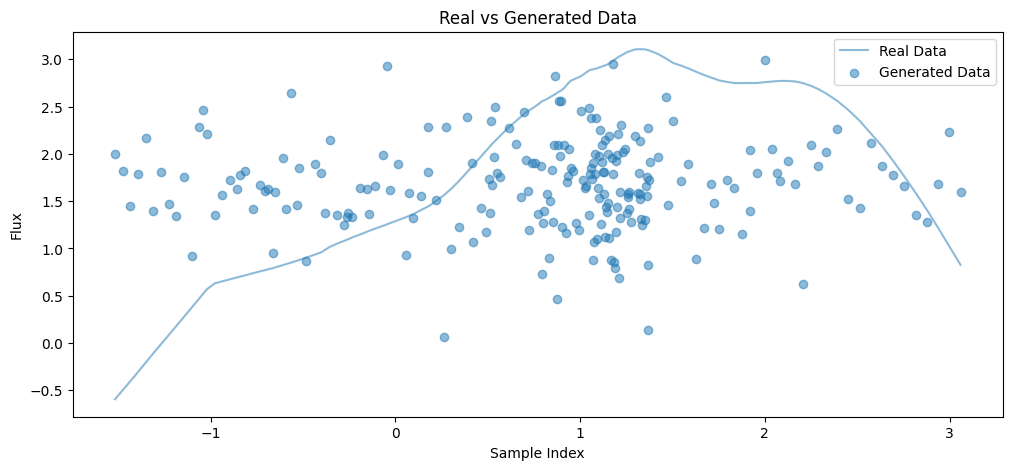

In [14]:
# Visualize generated data
with torch.no_grad():
    noise = torch.randn(223, latent_dim).to(device)
    generated_data = generator(noise).cpu().numpy()

# Plot real vs generated data
plt.figure(figsize=(12, 5))
plt.plot(sorted_wavelengths,df[:223,0], label='Real Data', alpha=0.5)
plt.scatter(sorted_wavelengths,generated_data[:223,0], label='Generated Data', alpha=0.5)
plt.title('Real vs Generated Data')
plt.xlabel('Sample Index')
plt.ylabel('Flux')
plt.legend()
plt.show()